<a href="https://colab.research.google.com/github/clayedw/RET-2024/blob/main/Redshift_binning_plots_together_7_9_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab

import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl as ccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



Redshift Distribution: The redshift distribution is defined and plotted.


Binning Class: The Binning class is defined to handle binning the redshift distribution into tomographic bins with equal number density.

Compute Equal Number Density Bins: The compute_equal_number_bounds method determines the bin edges that result in equal number densities.

Lens Bins: The lens_bins method computes the redshift distributions for each bin, normalizing them if specified.

Plotting: The redshift distributions for each bin are plotted to visualize the results.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy import integrate
import yaml

class SRDRedshiftDistributions:
    def __init__(self, redshift_range):
        self.redshift_range = redshift_range

    def smail_type_distribution(self, pivot_redshift, alpha, beta):
        redshift_distribution = [(z / pivot_redshift) ** beta * np.exp(-(z / pivot_redshift) ** alpha) for z in self.redshift_range]
        return np.array(redshift_distribution)

class Binning:
    def __init__(self, redshift_range, redshift_distribution, forecast_year):
        supported_forecast_years = {"1", "10"}
        if forecast_year in supported_forecast_years:
            self.forecast_year = forecast_year
        else:
            raise ValueError(f"forecast_year must be one of {supported_forecast_years}.")

        self.redshift_range = redshift_range
        self.redshift_distribution = redshift_distribution

        with open("lsst_desc_parameters.yaml", "r") as f:
            self.lsst_parameters = yaml.load(f, Loader=yaml.FullLoader)

        self.lens_params = self.lsst_parameters["lens_sample"][self.forecast_year]
        self.source_params = self.lsst_parameters["source_sample"][self.forecast_year]

    def true_redshift_distribution(self, upper_edge, lower_edge, variance, bias):
        scatter = variance * (1 + self.redshift_range)
        lower_limit = (upper_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        upper_limit = (lower_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        true_redshift_distribution = 0.5 * np.array(self.redshift_distribution) * (erf(upper_limit) - erf(lower_limit))
        return true_redshift_distribution

    def compute_equal_number_bounds(self, n_bins):
        cumulative_distribution = integrate.cumulative_trapezoid(self.redshift_distribution, self.redshift_range, initial=0)
        total_galaxies = cumulative_distribution[-1]
        bin_edges = []
        for i in range(1, n_bins):
            fraction = i / n_bins * total_galaxies
            bin_edge = np.interp(fraction, cumulative_distribution, self.redshift_range)
            bin_edges.append(bin_edge)
        return [self.redshift_range[0]] + bin_edges + [self.redshift_range[-1]]

    def lens_bins(self, normalised=True, save_file=True, file_format='npy'):
        bins = np.arange(self.lens_params["bin_start"],
                         self.lens_params["bin_stop"] + self.lens_params["bin_spacing"],
                         self.lens_params["bin_spacing"])

        lens_z_bias_list = np.repeat(self.lens_params["z_bias"], self.lens_params["n_tomo_bins"])
        lens_z_variance_list = np.repeat(self.lens_params["sigma_z"], self.lens_params["n_tomo_bins"])

        lens_redshift_distribution_dict = {}
        for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
            z_bias = lens_z_bias_list[index]
            z_variance = lens_z_variance_list[index]
            lens_redshift_distribution_dict[index] = self.true_redshift_distribution(x1, x2, z_variance, z_bias)

        if normalised:
            for key in lens_redshift_distribution_dict.keys():
                norm_factor = np.sum(lens_redshift_distribution_dict[key])
                lens_redshift_distribution_dict[key] /= norm_factor

        combined_data = {'redshift_range': self.redshift_range, 'bins': lens_redshift_distribution_dict}

        if save_file:
            self.save_to_file(combined_data, "lens", file_format)

        return lens_redshift_distribution_dict

    def get_bin_centers(self, decimal_places=2, save_file=True):
        bin_centers = {"sources": [], "lenses": []}
        lens_bins = self.lens_bins(normalised=True, save_file=False)
        for index in range(self.lens_params["n_tomo_bins"]):
            bin_center = self.find_bin_center(lens_bins[index], self.redshift_range, decimal_places)
            bin_centers["lenses"].append(bin_center)
        if save_file:
            np.save(f'./srd_bin_centers_y_{self.forecast_year}.npy', bin_centers)
        return bin_centers

    def find_bin_center(self, bin_distribution, redshift_range, decimal_places=2):
        max_index = np.argmax(bin_distribution)
        return round(redshift_range[max_index], decimal_places)

    def save_to_file(self, data, name, file_format="npy"):
        if file_format == "npy":
            np.save(f"./srd_{name}_bins_year_{self.forecast_year}.npy", data)
        elif file_format == "csv":
            import pandas as pd
            dndz_df = pd.DataFrame(data)
            dndz_df.to_csv(f"./srd_{name}_bins_year_{self.forecast_year}.csv", index=False)

# Define cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Define redshift range and distribution parameters
redshift_range = np.linspace(0.2, 1.2, 512)
beta = 2.0
alpha = 0.94
pivot_redshift = 0.26

# Instantiate SRDRedshiftDistributions and get redshift distribution
srd = SRDRedshiftDistributions(redshift_range)
redshift_distribution = srd.smail_type_distribution(pivot_redshift, alpha, beta)

# Instantiate and use the Binning class
forecast_year = "1"  # For year 1
binning = Binning(redshift_range, redshift_distribution, forecast_year)

# Compute equal number density bins
n_bins = 5  # Number of bins for year 1
bin_edges = binning.compute_equal_number_bounds(n_bins)
print("Bin edges:", bin_edges)

# Compute the redshift distributions for each bin
lens_bins = binning.lens_bins(normalised=True, save_file=False)
#print("Lens bins:", lens_bins)

# Compute the redshift distributions for each bin
lens_bins = binning.lens_bins(normalised=True, save_file=False)

# Create NumberCountsTracer objects for each bin
tracers = []
for i in range(n_bins):
    z_bin = redshift_range[(redshift_range >= bin_edges[i]) & (redshift_range < bin_edges[i+1])]
    dNdz_bin = redshift_distribution[(redshift_range >= bin_edges[i]) & (redshift_range < bin_edges[i+1])]
    bias_bin = np.ones_like(z_bin)  # Assuming a constant bias for simplicity
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, bias_bin))
    tracers.append(tracer)

# Specify angular multipoles
ell = np.arange(2, 2000)

# Calculate angular power spectra
cls = []
for tracer in tracers:
    cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin
correlations = []
for cl in cls:
    xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_deg, type='NN', method='FFTLog')
    correlations.append(xi_clu)

# Compute the true redshift distribution (no photo-z uncertainty) for each bin
true_lens_redshift_distribution_dict = {}
for index, (x1, x2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    mask = (redshift_range >= x1) & (redshift_range < x2)
    z_bin = redshift_range[mask]
    true_lens_redshift_distribution_dict[index] = srd.smail_type_distribution(pivot_redshift, alpha, beta)[mask]

# Create the NumberCountsTracer objects for each bin with true redshift distribution
true_tracers = []
for i in range(len(bin_edges) - 1):
    z_bin = redshift_range[(redshift_range >= bin_edges[i]) & (redshift_range < bin_edges[i+1])]
    dNdz_bin = true_lens_redshift_distribution_dict[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
    true_tracers.append(tracer)

# Calculate the angular power spectra for each bin (auto-correlations) with true redshift distribution
true_cls_matrix = np.zeros((len(bin_edges) - 1, len(ell)))
for i in range(len(bin_edges) - 1):
    true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin with true redshift distribution
true_correlations_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
for i in range(len(bin_edges) - 1):
    true_cls = true_cls_matrix[i]
    true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls, theta=theta_deg, type='NN', method='FFTLog')

# Calculate the correlation function for the original redshift bins
correlations_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
for i in range(len(bin_edges) - 1):
    cls_bin = cls[i]
    correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=cls_bin, theta=theta_deg, type='NN', method='FFTLog')


Bin edges: [0.2, 0.424781214083455, 0.5912747293753566, 0.758193805786884, 0.9489832596084801, 1.2]


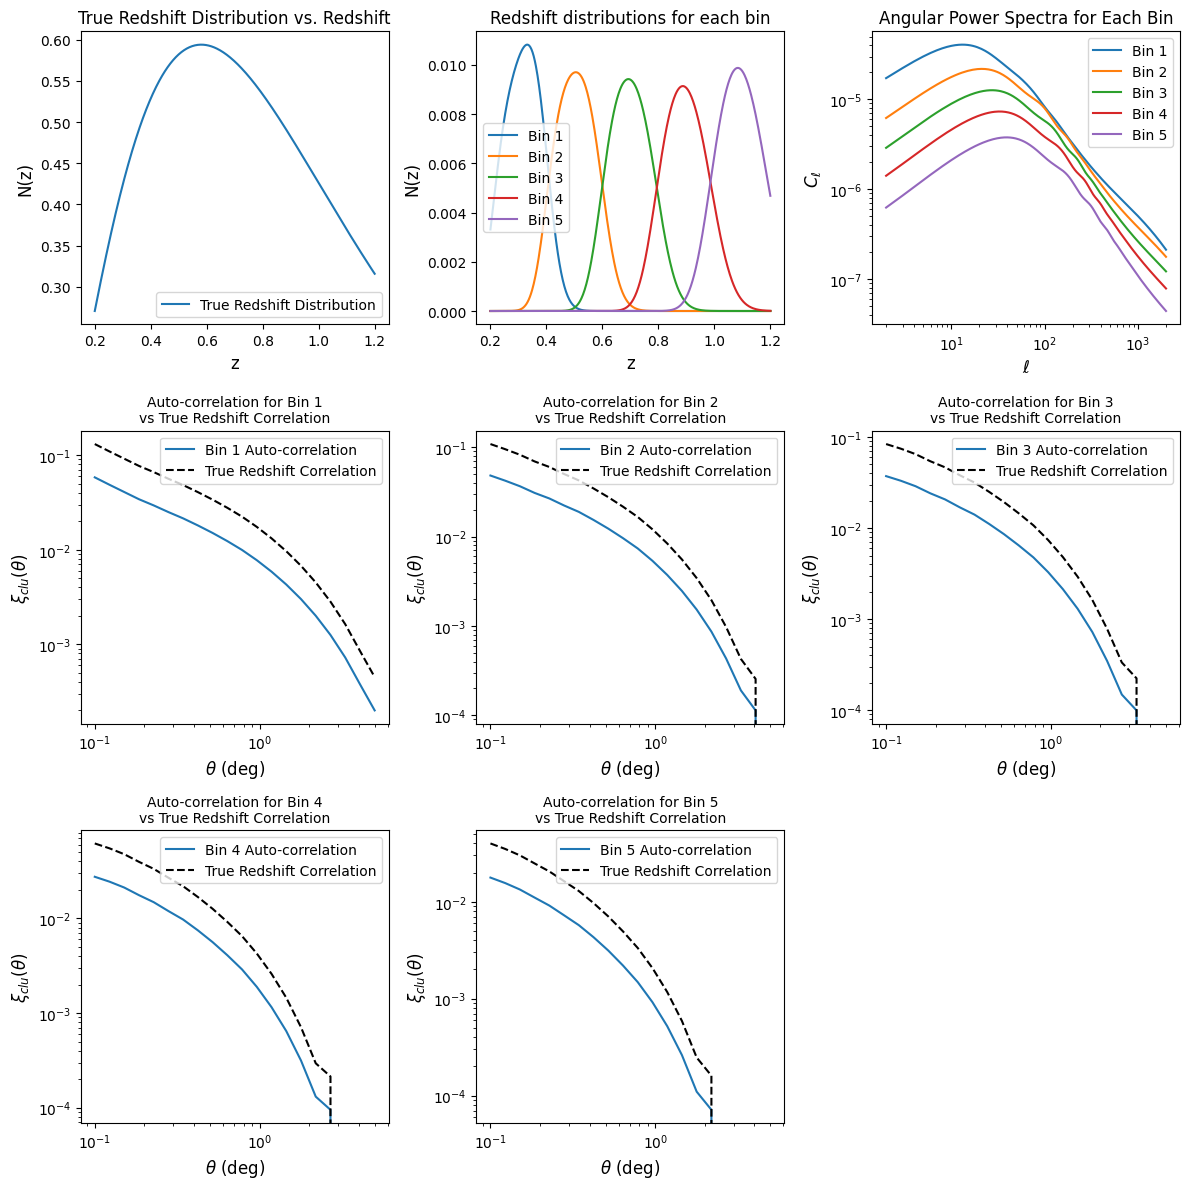

In [12]:
# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Plot the true redshift distribution
axes[0, 0].plot(redshift_range, redshift_distribution, label='True Redshift Distribution')
axes[0, 0].set_xlabel('z', fontsize=12)
axes[0, 0].set_ylabel('N(z)', fontsize=12)
axes[0, 0].set_title('True Redshift Distribution vs. Redshift', fontsize=12)
axes[0, 0].legend()

# Plot the redshift distributions for each bin
for i in range(n_bins):
    axes[0, 1].plot(redshift_range, lens_bins[i], label=f'Bin {i+1}')
axes[0, 1].set_xlabel('z', fontsize=12)
axes[0, 1].set_ylabel('N(z)', fontsize=12)
axes[0, 1].set_title('Redshift distributions for each bin', fontsize=12)
axes[0, 1].legend()

# Plot the angular power spectra
for i, cl in enumerate(cls):
    axes[0, 2].plot(ell, cl, label=f'Bin {i+1}')
axes[0, 2].set_xlabel('$\\ell$', fontsize=12)
axes[0, 2].set_ylabel('$C_\\ell$', fontsize=12)
axes[0, 2].set_xscale('log')
axes[0, 2].set_yscale('log')
axes[0, 2].legend()
axes[0, 2].set_title('Angular Power Spectra for Each Bin', fontsize=12)

# Plot the auto-correlation for each bin compared to the true redshift distribution correlation
for j, (xi_clu, true_corr) in enumerate(zip(correlations_matrix, true_correlations_matrix)):
    row = (j // 3) + 1
    col = (j % 3)
    axes[row, col].plot(theta_deg, xi_clu, label=f'Bin {j+1} Auto-correlation')
    axes[row, col].plot(theta_deg, true_corr, label='True Redshift Correlation', color='black', linestyle='--')
    axes[row, col].set_xscale('log')
    axes[row, col].set_yscale('log')
    axes[row, col].legend(loc='upper right', fontsize=10)
    axes[row, col].set_xlabel(r'$\theta$ (deg)', fontsize=12)
    axes[row, col].set_ylabel(r'$\xi_{clu} (\theta)$', fontsize=12)
    axes[row, col].set_title(f'Auto-correlation for Bin {j+1}\nvs True Redshift Correlation', fontsize=10)

# Hide the last subplot
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def check_peak_variation(redshift_range, redshift_distribution, correlations_matrix, true_correlations_matrix, ell, theta_deg, alpha_range=(0.0, 8.0), beta_range=(0.0, 8.0)):
    alpha_values = np.linspace(alpha_range[0], alpha_range[1], num=10)  # Adjust num as needed for finer resolution
    beta_values = np.linspace(beta_range[0], beta_range[1], num=10)  # Adjust num as needed for finer resolution

    peak_values = []

    for alpha in alpha_values:
        for beta in beta_values:
            # Recompute redshift distribution using current alpha and beta
            redshift_distribution = srd.smail_type_distribution(pivot_redshift, alpha, beta)

            # Recompute lens bins with updated redshift distribution
            lens_bins = binning.lens_bins(normalised=True, save_file=False)

            # Recompute tracers and angular power spectra
            tracers = []
            for i in range(n_bins):
                z_bin = redshift_range[(redshift_range >= bin_edges[i]) & (redshift_range < bin_edges[i+1])]
                dNdz_bin = redshift_distribution[(redshift_range >= bin_edges[i]) & (redshift_range < bin_edges[i+1])]
                bias_bin = np.ones_like(z_bin)  # Assuming a constant bias for simplicity
                tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, bias_bin))
                tracers.append(tracer)

            cls = []
            for tracer in tracers:
                cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

            # Recompute correlations and true correlations
            correlations = []
            for cl in cls:
                xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_deg, type='NN', method='FFTLog')
                correlations.append(xi_clu)

            true_tracers = []
            for i in range(len(bin_edges) - 1):
                z_bin = redshift_range[(redshift_range >= bin_edges[i]) & (redshift_range < bin_edges[i+1])]
                dNdz_bin = true_lens_redshift_distribution_dict[i]
                tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
                true_tracers.append(tracer)

            true_cls_matrix = np.zeros((len(bin_edges) - 1, len(ell)))
            for i in range(len(bin_edges) - 1):
                true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

            true_correlations_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
            for i in range(len(bin_edges) - 1):
                true_cls = true_cls_matrix[i]
                true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls, theta=theta_deg, type='NN', method='FFTLog')

            # Calculate peak values
            peak_value = np.max(true_correlations_matrix)  # Assuming peak value is the maximum of the true correlation matrix
            peak_values.append((alpha, beta, peak_value))

    return peak_values

# Example usage:
peak_values = check_peak_variation(redshift_range, redshift_distribution, correlations_matrix, true_correlations_matrix, ell, theta_deg)
for alpha, beta, peak_value in peak_values:
    print(f"Alpha: {alpha}, Beta: {beta}, Peak Value: {peak_value}")


CCLError: Error CCL_ERROR_INTEG: ccl_cls.c: ccl_angular_cls_limber(); integration error
